#### DEMONSTRAÇÃO DA PREVISÃO DE DEMANDA DE VENDAS BASEADAS EM DADOS HISTÓRICOS COM REDES NEURAIS RECORRENTES DE MULTIPLAS CAMADAS E APERFEIÇOAMENTO DOS HIPERPARAMÊTROS DO MODELO POR MEIO DE ALGORITMOS GENÉTICOS
#### FORAM ANALISADAS APENAS ORDENS EFETIVAMENTE ENVIADAS

### Preludio

In [47]:
#bibliotecas basicas
import pandas as pd
import numpy as np
import tensorflow.compat.v1 as v1

#geração de gráficos
import matplotlib.pyplot as plt

#bibliotecas para o aprendizado de maquina
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import SGDRegressor
from sklearn.neural_network import MLPRegressor


### Pré Processamento

In [ ]:
### Carregamento e pre processamento da base de dados

In [48]:
dataset = pd.read_csv('./archive/sales_data_sample.csv', engine='python')
dataset.drop(['ORDERNUMBER', 'CONTACTFIRSTNAME', 'CONTACTLASTNAME', 'COUNTRY',
              'TERRITORY', 'STATE', 'POSTALCODE', 'CITY',
              'ADDRESSLINE2', 'ADDRESSLINE1', 'PHONE', 'CUSTOMERNAME',
              'ORDERLINENUMBER'], axis=1, inplace=True)
dataset_remove = dataset.loc[(dataset['STATUS'] != 'Shipped')]
dataset.drop(dataset_remove.index, inplace=True)
dataset['ORDERDATE']= pd.Index(pd.to_datetime(dataset['ORDERDATE'])) 
dataset['DEALSIZE'] = dataset['DEALSIZE'].replace(['Small'], int(0))    
dataset['DEALSIZE'] = dataset['DEALSIZE'].replace(['Medium'], int(1))    
dataset['DEALSIZE'] = dataset['DEALSIZE'].replace(['Large'], int(2))   

dataset['PRODUCTLINE'] = dataset['PRODUCTLINE'].replace(['Motorcycles'], int(0))    
dataset['PRODUCTLINE'] = dataset['PRODUCTLINE'].replace(['Classic Cars'], int(1))
dataset['PRODUCTLINE'] = dataset['PRODUCTLINE'].replace(['Trucks and Buses'], int(2))
dataset['PRODUCTLINE'] = dataset['PRODUCTLINE'].replace(['Vintage Cars'], int(3))
dataset['PRODUCTLINE'] = dataset['PRODUCTLINE'].replace(['Planes'], int(4))
dataset['PRODUCTLINE'] = dataset['PRODUCTLINE'].replace(['Ships'], int(5))
dataset['PRODUCTLINE'] = dataset['PRODUCTLINE'].replace(['Trains'], int(6))


In [ ]:
### Analise de algumas correlações

In [49]:
def correlacao(correlacao):
    if 0 < correlacao < 0.3 or -0.3 < correlacao < 0:
        return ('correlação desprezivel', correlacao)
    if 0.3 < correlacao < 0.5 or -0.5 < correlacao < -0.3:
        return ('correlação fraca', correlacao)
    if 0.5 < correlacao < 0.7 or -0.7 < correlacao < -0.5:
        return ('correlação moderada', correlacao)
    if 0.7 < correlacao < 0.9 or -0.9 < correlacao < -0.7:
        return ('correlação forte', correlacao)
    if 0.9 < correlacao < 1 or -1 < correlacao < -0.9:
        return ('correlação muito forte', correlacao)
                
correlacoes = [dataset['PRICEEACH'].corr(dataset['MSRP'], method='spearman'), 
                    dataset['PRICEEACH'].corr(dataset['SALES'], method='spearman'), 
                    dataset['DEALSIZE'].astype(int).corr(dataset['SALES'].astype(int), method='spearman'),
                    dataset['PRODUCTLINE'].astype(int).corr(dataset['SALES'].astype(int), method='spearman'),
                    dataset['PRODUCTLINE'].astype(int).corr(dataset['PRICEEACH'].astype(int), method='spearman')]
                
for corr in correlacoes:
    print(correlacao(corr))

('correlação forte', 0.7546110229287264)
('correlação forte', 0.7939684322976108)
('correlação forte', 0.8876511192844363)
('correlação desprezivel', -0.15912742460411147)
('correlação desprezivel', -0.14951747732890852)


In [ ]:
### Analise de todas variações 

In [50]:
dataset.corr(method='spearman').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,QUANTITYORDERED,PRICEEACH,SALES,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,DEALSIZE
QUANTITYORDERED,1.0,0.0019,0.53,-0.02,-0.017,0.029,-0.0056,0.018,0.45
PRICEEACH,0.0019,1.0,0.79,0.0052,0.0017,0.00073,-0.15,0.75,0.69
SALES,0.53,0.79,1.0,-0.0012,-0.0017,0.013,-0.16,0.67,0.89
QTR_ID,-0.02,0.0052,-0.0012,1.0,0.96,-0.36,-0.015,0.0035,-0.0056
MONTH_ID,-0.017,0.0017,-0.0017,0.96,1.0,-0.35,-0.006,0.00061,-0.0046
YEAR_ID,0.029,0.00073,0.013,-0.36,-0.35,1.0,0.00023,-0.0073,-0.005
PRODUCTLINE,-0.0056,-0.15,-0.16,-0.015,-0.006,0.00023,1.0,-0.25,-0.15
MSRP,0.018,0.75,0.67,0.0035,0.00061,-0.0073,-0.25,1.0,0.59
DEALSIZE,0.45,0.69,0.89,-0.0056,-0.0046,-0.005,-0.15,0.59,1.0


In [ ]:
"""Percebe-se que as maiores correlações e relevantes são as seguintes: 
QUANTITYORDEREDxSALES (moderada, 0.53)
DEALSIZExPRICEEACH (moderada, 0.69)
PRICEEACHxSALES (forte, 0.79)
EALSIZExSALES (forte, 0.89)
É apresentado abaixo um gráfico de disperção relacionando o tamanho do estabecimento e a quantidade vendida."""

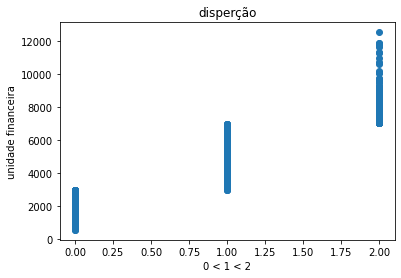

In [51]:
plt.scatter(dataset[['DEALSIZE']], dataset[['SALES']])
plt.xlabel("0 < 1 < 2")
plt.ylabel("unidade financeira")
plt.title('disperção')
plt.show()

In [ ]:
### Apresenta-se o que já era esperado, as lojas maiores vendem um volume financeiro maior

In [52]:
dataset_small = dataset.loc[(dataset['DEALSIZE'] == 0)]
dataset_medium = dataset.loc[(dataset['DEALSIZE'] == 1)]
dataset_large = dataset.loc[(dataset['DEALSIZE'] == 2)]
dataset_daily_data = dataset.sort_values('ORDERDATE')


In [53]:
prod_id = list()
for index, row in dataset_daily_data.iterrows():
    prod_id.append(row['PRODUCTCODE'])
prod_id = set(prod_id)

In [54]:
dataset['TOTAL'] = None
for id in prod_id:
    total = []
    last_index = None
    for index, row in dataset_daily_data.iterrows():
        if id == row['PRODUCTCODE']:
            total.append(row['SALES'])
            last_index = index
    dataset_daily_data.loc[last_index, 'TOTAL'] = sum(total)
    total = []

In [ ]:
"""Até esse momento foi feita uma analise de correlação entre as variaveis do banco de dados 
e dividimos nossa base de dados em outras três, de acordo com o tamanho do estabelecimento. 
Com isso, iremos escolher um produto vendido em um determinado estabelecimento e aplicar 
a ele a predição com uma rede neural recorrente. 
Portanto, é a partir daqui que a previsão de demanda abordada no trabalho final acontece.
Antes é plotado a nossa base de dados completa"""

In [64]:
dataset_daily_data.head(3)

,QUANTITYORDERED,PRICEEACH,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,DEALSIZE,TOTAL
2024,49,34.47,1689.03,2003-01-06,Shipped,1,1,2003,3,41,S24_3969,0,NaN
578,30,100.00,5151.00,2003-01-06,Shipped,1,1,2003,3,170,S18_1749,1,NaN
680,50,67.80,3390.00,2003-01-06,Shipped,1,1,2003,3,60,S18_2248,1,NaN


### Processamento

In [57]:
#serapação do banco de dados em um só produto, cujo id é S18_3232. 
#ao rodar a célula, uma descrição do dataframe aparecerá
is_S18_3232 = dataset['PRODUCTCODE'] == 'S18_3232'
dataset_only_S18_3232 = dataset[is_S18_3232]
dataset_for_process = dataset_only_S18_3232.copy()
dataset_for_process.drop(['QUANTITYORDERED', 'PRICEEACH', 'STATUS', 'QTR_ID',
                          'MONTH_ID', 'YEAR_ID', 'PRODUCTLINE', 'MSRP', 'PRODUCTCODE',
                          'DEALSIZE', 'TOTAL'], axis=1, inplace=True)


In [58]:
dataset_for_process.set_index('ORDERDATE', inplace=True)

In [ ]:
### A seguir é plotado a base de dados para treinamente e teste para a predição das vendas do produto S18_3232

In [63]:
dataset_for_process.head(3)

,SALES
ORDERDATE,
2003-01-31,4556.99
2003-03-10,8257.00
2003-04-01,8209.44


In [59]:
#criação da variavel scalar para a normalização e divião da base de dados em dados de treino e de teste
scalar = MinMaxScaler()
train = dataset_for_process.head(38)
test = dataset_for_process.tail(11)

train_normalizer = scalar.fit_transform(train)
test_normalizer = scalar.fit_transform(test)

In [60]:
def proximo_lote(dados_treino, tamanho_lote, passos):
    np.random.seed(1)
    random_start = np.random.randint(0, len(dados_treino) - passos)
    #criando dados de y para serie temporal do lote
    y_lote = np.array(dados_treino[random_start:random_start+passos+1]).reshape(1,passos+1)
    x_lote = y_lote[:,:-1].reshape(-1, passos, 1)
    y_lote = y_lote[:, 1:].reshape(-1, passos, 1)
    return x_lote, y_lote
    

In [ ]:
### Criação da rede neural recorrente

In [61]:
#criação do hiperparametros
num_inputs = 1
num_time_steps = 12
num_neurons = 100
num_outputs = 1
learnig_rate = 0.01
num_train_iterations = 4000
batch_size = 1
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()
x = v1.placeholder(v1.float32, [None, num_time_steps, num_inputs])
y = v1.placeholder(v1.float32, [None, num_time_steps, num_outputs])

cell = v1.nn.rnn_cell.DropoutWrapper(v1.nn.rnn_cell.GRUCell(num_units=num_neurons, activation=v1.nn.relu))
output, state = v1.nn.dynamic_rnn(cell, x, dtype=v1.float32)

loss = tf.reduce_mean(v1.square(output -y))
opitimizer = v1.train.AdamOptimizer(learning_rate=learnig_rate)
trainn = opitimizer.minimize(loss)
init = v1.global_variables_initializer()

"""saver = v1.train.Saver()
with v1.Session() as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = proximo_lote(train_normalizer, batch_size,num_time_steps)
        sess.run(train, feed_dict={x: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={x: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
        saver.save(sess, "./ex_time_series_soumil")"""

'saver = v1.train.Saver()\nwith v1.Session() as sess:\n    sess.run(init)\n    \n    for iteration in range(num_train_iterations):\n        \n        X_batch, y_batch = proximo_lote(train_normalizer, batch_size,num_time_steps)\n        sess.run(train, feed_dict={x: X_batch, y: y_batch})\n        \n        if iteration % 100 == 0:\n            \n            mse = loss.eval(feed_dict={x: X_batch, y: y_batch})\n            print(iteration, "\tMSE:", mse)\n        saver.save(sess, "./ex_time_series_soumil")'